<a href="https://colab.research.google.com/github/paulcodrea/reddit_humor/blob/main/Humour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Get reddit /r/dadjokes data
import requests
import pandas as pd

url = "https://www.reddit.com/r/dadjokes.json"
resp = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'limit': '100'})
data = resp.json()
data_list = []
data_list.append(data)
# repeat process 9 more times with updated 'after' param
for i in range(100):
  after_param = data['data']['after'] 
  data = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'after': after_param, 'limit': '100'})
  data_2 = data.json()
  data_list.append(data_2)
  data = data_2

In [46]:
# create a list of all jokes in json format
data = []
for collection in data_list:
  collection_list = collection['data']['children']
  for joke_index in range(len(collection_list)):
    data.append(collection_list[joke_index]['data'])

In [53]:
print(data[0])
print(data[0]['ups'])
print(data[0]['upvote_ratio'])
print(len(data))

{'approved_at_utc': None, 'subreddit': 'dadjokes', 'selftext': 'Thunder wear.', 'author_fullname': 't2_eadxaxh3', 'saved': False, 'mod_reason_title': None, 'gilded': 0, 'clicked': False, 'title': 'what do clouds wear?', 'link_flair_richtext': [], 'subreddit_name_prefixed': 'r/dadjokes', 'hidden': False, 'pwls': 6, 'link_flair_css_class': None, 'downs': 0, 'thumbnail_height': None, 'top_awarded_type': None, 'hide_score': False, 'name': 't3_u7u5mf', 'quarantine': False, 'link_flair_text_color': 'dark', 'upvote_ratio': 0.98, 'author_flair_background_color': None, 'subreddit_type': 'public', 'ups': 1032, 'total_awards_received': 1, 'media_embed': {}, 'thumbnail_width': None, 'author_flair_template_id': None, 'is_original_content': False, 'user_reports': [], 'secure_media': None, 'is_reddit_media_domain': False, 'is_meta': False, 'category': None, 'secure_media_embed': {}, 'link_flair_text': None, 'can_mod_post': False, 'score': 1032, 'approved_by': None, 'is_created_from_ads_ui': False, 'a

### Save only important columns in dataframe

In [54]:
df = pd.DataFrame(data)
clean_df = pd.DataFrame()

clean_df['title'] = df['title']
clean_df['selftext'] = df['selftext']
clean_df['ups'] = df['ups']
clean_df['downs'] = df['downs']
clean_df['upvote_ratio'] = df['upvote_ratio']
clean_df['total_awards_received'] = df['total_awards_received']

In [55]:
# save the jokes in a csv file for later use
clean_df.to_csv(f'1_reddit_dadjokes({len(clean_df)}).csv')

### Plot the stats of the reddit jokes

Number of jokes with upvotes different from zero:  8997
Number of jokes with downvotes different from zero:  0
Number of jokes with no engagement:  619
Average upvote ratio:  0.8387863976705424


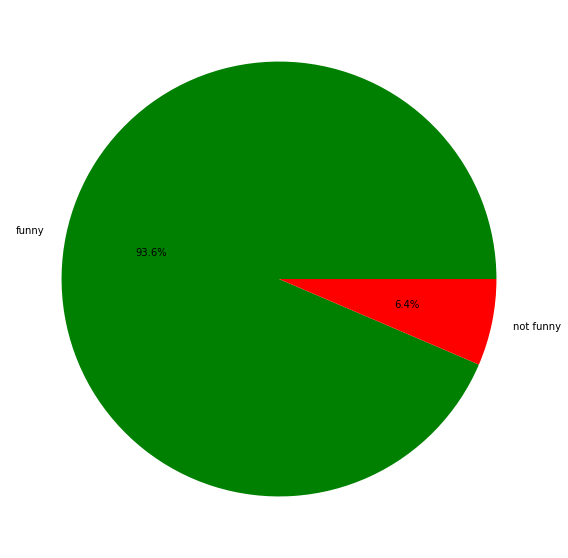

In [56]:
# print out as a pie chart how many jokes are funny or not
from matplotlib import pyplot as plt

# calculate number of posts with upvotes different grater than downvotes
funny = clean_df[clean_df['ups'] > clean_df['downs']]
not_funny = clean_df[clean_df['ups'] <= clean_df['downs']]
no_engagement = len(clean_df[(clean_df['ups'] == 0) & (clean_df['downs'] == 0)])


#calculate how many have only upvotes and zero downvotes
upvotes_count = downvotes_count = 0
for index in range(len(clean_df)):
    if clean_df['ups'][index] > 0:
        upvotes_count += 1
    elif clean_df['downs'][index] > 0:
        downvotes_count += 1

print("Number of jokes with upvotes different from zero: ", upvotes_count)
print("Number of jokes with downvotes different from zero: ", downvotes_count)
print("Number of jokes with no engagement: ", no_engagement)

# print average of the upvote ratio
print("Average upvote ratio: ", clean_df['upvote_ratio'].mean())


funny_percentage = len(funny) / len(clean_df) * 100
not_funny_percentage = len(not_funny) / len(clean_df) * 100

# set size of pie chart
plt.figure(figsize=(10,10))
plt.pie([funny_percentage, not_funny_percentage], labels=['funny', 'not funny'], autopct='%1.1f%%', colors=['green', 'red'])
plt.show()

Experimenting to find a threshold 

In [62]:
average = 0
average_ratio = 0
unfunny_but_awarded = 0
funny = 0
# hardcoded from the average and average_ratio variables
threshold = 212
threshold_ratio = 0.83

for index in range(len(clean_df)):
  #  if the post has upvotes above the threshold OR the upvote_ratio is above the threshold
  # if clean_df['ups'][index] > threshold or clean_df['upvote_ratio'][index] > threshold_ratio:
  if clean_df['ups'][index] > threshold and clean_df['upvote_ratio'][index] > threshold_ratio:
    funny = funny + 1
  # if they don't have enough upvotes or ratio but have awards -> possible funny
  elif int(clean_df['total_awards_received'][index]) > 2 and clean_df['upvote_ratio'][index] > threshold_ratio:
    unfunny_but_awarded = unfunny_but_awarded +1

  average = average + clean_df['ups'][index]
  average_ratio = average_ratio + clean_df['upvote_ratio'][index]

print('total ', len(clean_df))
print('average is ', str(average/len(clean_df)))
print('average ratio is ', str(average_ratio/len(clean_df)))
print('not that funny but have awards ', unfunny_but_awarded)
print('funny ', funny)
print('funny ratio ', funny/len(clean_df))


total  9616
average is  212.67242096505822
average ratio is  0.8387863976705424
not that funny but have awards  11
funny  670
funny ratio  0.06967554076539101
